# NB04: Conservation Architecture

Connect essential gene families to pangenome conservation status (core/accessory/singleton).

**Input**: Essential genes, ortholog groups, families from NB02, pangenome link table from `conservation_vs_fitness`
**Output**: `data/family_conservation.tsv`, figures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
CV_DIR = Path('../../conservation_vs_fitness/data')

essential = pd.read_csv(DATA_DIR / 'all_essential_genes.tsv', sep='\t', low_memory=False)
essential['is_essential'] = essential['is_essential'].astype(str).str.strip().str.lower() == 'true'
essential['locusId'] = essential['locusId'].astype(str)

og_df = pd.read_csv(DATA_DIR / 'all_ortholog_groups.csv')
og_df['locusId'] = og_df['locusId'].astype(str)

families = pd.read_csv(DATA_DIR / 'essential_families.tsv', sep='\t')

link = pd.read_csv(CV_DIR / 'fb_pangenome_link.tsv', sep='\t')
link['locusId'] = link['locusId'].astype(str)

pg_meta = pd.read_csv(CV_DIR / 'pangenome_metadata.tsv', sep='\t')
org_mapping = pd.read_csv(CV_DIR / 'organism_mapping.tsv', sep='\t')

print(f"Link table: {len(link):,} gene-cluster links, {link['orgId'].nunique()} organisms")

Link table: 177,863 gene-cluster links, 44 organisms


## Core genome fraction by essentiality

In [2]:
ess_conservation = essential.merge(
    link[['orgId', 'locusId', 'is_core', 'is_auxiliary', 'is_singleton']],
    on=['orgId', 'locusId'], how='inner'
)

ess_core = ess_conservation[ess_conservation['is_essential']]
noness_core = ess_conservation[~ess_conservation['is_essential']]

print(f"Essential genes: {ess_core['is_core'].mean()*100:.1f}% core (n={len(ess_core):,})")
print(f"Non-essential: {noness_core['is_core'].mean()*100:.1f}% core (n={len(noness_core):,})")

Essential genes: 85.3% core (n=31,391)
Non-essential: 80.7% core (n=142,183)


## Conservation by essentiality class

In [3]:
# Add OG and class
ess_conservation = ess_conservation.merge(og_df[['orgId', 'locusId', 'OG_id']], on=['orgId', 'locusId'], how='left')
ess_conservation = ess_conservation.merge(families[['OG_id', 'essentiality_class']], on='OG_id', how='left')

ess_conservation.loc[
    ess_conservation['essentiality_class'].isna() & ess_conservation['is_essential'],
    'essentiality_class'] = 'orphan_essential'
ess_conservation.loc[
    ess_conservation['essentiality_class'].isna() & ~ess_conservation['is_essential'],
    'essentiality_class'] = 'no_og'

for cls in ['universally_essential', 'variably_essential', 'never_essential', 'orphan_essential']:
    s = ess_conservation[ess_conservation['essentiality_class'] == cls]
    if len(s) > 0:
        print(f"{cls}: {s['is_core'].mean()*100:.1f}% core (n={len(s):,})")

universally_essential: 91.7% core (n=6,963)


variably_essential: 88.9% core (n=90,844)
never_essential: 81.7% core (n=47,140)
orphan_essential: 49.5% core (n=4,683)


## Per-family conservation

In [4]:
family_conservation = []
for og_id, group in ess_conservation[ess_conservation['OG_id'].notna()].groupby('OG_id'):
    fam_info = families[families['OG_id'] == og_id]
    if len(fam_info) == 0:
        continue
    fam = fam_info.iloc[0]
    family_conservation.append({
        'OG_id': og_id, 'essentiality_class': fam['essentiality_class'],
        'pct_core': group['is_core'].mean() * 100, 'n_genes': len(group),
        'n_organisms': group['orgId'].nunique(),
        'n_essential_organisms': fam['n_essential_organisms'],
        'frac_essential': fam['frac_essential'],
        'rep_gene': fam['rep_gene'], 'rep_desc': fam['rep_desc'],
    })

fam_cons = pd.DataFrame(family_conservation)
fam_cons.to_csv(DATA_DIR / 'family_conservation.tsv', sep='\t', index=False)

for cls in ['universally_essential', 'variably_essential', 'never_essential']:
    s = fam_cons[fam_cons['essentiality_class'] == cls]
    print(f"{cls}: median {s['pct_core'].median():.1f}% core (n={len(s):,})")

univ_fams = fam_cons[fam_cons['essentiality_class'] == 'universally_essential']
n100 = (univ_fams['pct_core'] == 100).sum()
n90 = (univ_fams['pct_core'] >= 90).sum()
print(f"\nUniversally essential: {n100}/{len(univ_fams)} 100% core, {n90}/{len(univ_fams)} >=90% core")

universally_essential: median 100.0% core (n=816)
variably_essential: median 96.4% core (n=4,736)
never_essential: median 100.0% core (n=11,206)

Universally essential: 579/816 100% core, 670/816 >=90% core


## Penetrance vs conservation correlation

In [5]:
var_with_core = fam_cons[fam_cons['essentiality_class'] == 'variably_essential']
rho, p = stats.spearmanr(var_with_core['frac_essential'], var_with_core['pct_core'])
print(f"Penetrance vs conservation: rho={rho:.4f}, p={p:.2e}")

high_pen = var_with_core[var_with_core['frac_essential'] > 0.8]['pct_core'].median()
low_pen = var_with_core[var_with_core['frac_essential'] < 0.2]['pct_core'].median()
print(f"  >80% penetrance: {high_pen:.1f}% core")
print(f"  <20% penetrance: {low_pen:.1f}% core")

Penetrance vs conservation: rho=0.1233, p=1.62e-17
  >80% penetrance: 97.1% core
  <20% penetrance: 92.8% core


## Clade size vs essentiality rate

In [6]:
org_ess_stats = essential.groupby('orgId').agg(
    n_genes=('locusId', 'count'), n_essential=('is_essential', 'sum')).reset_index()
org_ess_stats['pct_essential'] = org_ess_stats['n_essential'] / org_ess_stats['n_genes'] * 100

org_meta = org_mapping.merge(pg_meta, on='gtdb_species_clade_id', how='inner')
org_ess_stats = org_ess_stats.merge(
    org_meta[['orgId', 'no_genomes', 'no_core', 'no_gene_clusters']], on='orgId', how='left')

has_pg = org_ess_stats.dropna(subset=['no_genomes'])
rho_g, p_g = stats.spearmanr(has_pg['no_genomes'], has_pg['pct_essential'])
print(f"Clade size vs % essential: rho={rho_g:.3f}, p={p_g:.3e}")

Clade size vs % essential: rho=-0.132, p=3.576e-01


## Figure: Conservation architecture

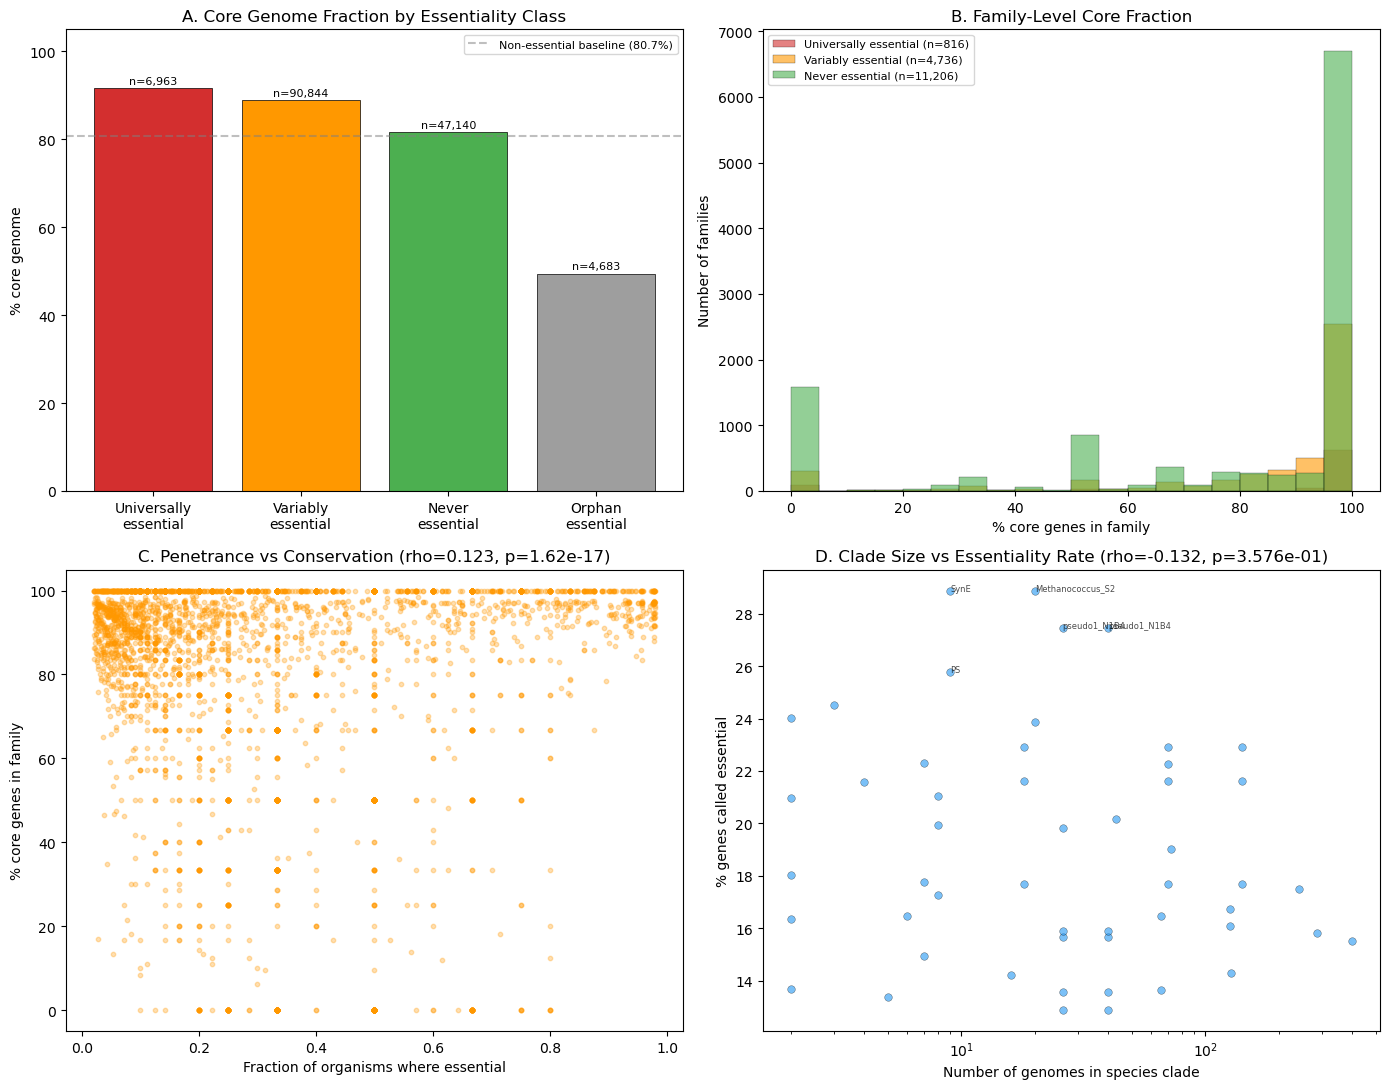

In [7]:
noness_pct_core = noness_core['is_core'].mean() * 100
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Panel A
ax = axes[0, 0]
plot_classes = ['universally_essential', 'variably_essential', 'never_essential', 'orphan_essential']
plot_labels = ['Universally\nessential', 'Variably\nessential', 'Never\nessential', 'Orphan\nessential']
colors = ['#D32F2F', '#FF9800', '#4CAF50', '#9E9E9E']
core_pcts, ns = [], []
for cls in plot_classes:
    s = ess_conservation[ess_conservation['essentiality_class'] == cls]
    core_pcts.append(s['is_core'].mean() * 100 if len(s) > 0 else 0)
    ns.append(len(s))
bars = ax.bar(plot_labels, core_pcts, color=colors, edgecolor='black', linewidth=0.5)
for bar, n in zip(bars, ns):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'n={n:,}', ha='center', va='bottom', fontsize=8)
ax.set_ylabel('% core genome')
ax.set_title('A. Core Genome Fraction by Essentiality Class')
ax.set_ylim(0, 105)
ax.axhline(noness_pct_core, color='gray', linestyle='--', alpha=0.5,
           label=f'Non-essential baseline ({noness_pct_core:.1f}%)')
ax.legend(fontsize=8)

# Panel B
ax = axes[0, 1]
for cls, color, label in zip(
    ['universally_essential', 'variably_essential', 'never_essential'],
    ['#D32F2F', '#FF9800', '#4CAF50'],
    ['Universally essential', 'Variably essential', 'Never essential']):
    s = fam_cons[fam_cons['essentiality_class'] == cls]
    if len(s) > 0:
        ax.hist(s['pct_core'], bins=20, alpha=0.6, color=color,
                label=f'{label} (n={len(s):,})', edgecolor='black', linewidth=0.3)
ax.set_xlabel('% core genes in family')
ax.set_ylabel('Number of families')
ax.set_title('B. Family-Level Core Fraction')
ax.legend(fontsize=8)

# Panel C
ax = axes[1, 0]
ax.scatter(var_with_core['frac_essential'], var_with_core['pct_core'],
           alpha=0.3, s=10, color='#FF9800')
ax.set_xlabel('Fraction of organisms where essential')
ax.set_ylabel('% core genes in family')
ax.set_title(f'C. Penetrance vs Conservation (rho={rho:.3f}, p={p:.2e})')

# Panel D
ax = axes[1, 1]
if len(has_pg) > 0:
    ax.scatter(has_pg['no_genomes'], has_pg['pct_essential'],
               alpha=0.6, s=30, color='#2196F3', edgecolor='black', linewidth=0.3)
    for _, r in has_pg.iterrows():
        if r['no_genomes'] > 1000 or r['pct_essential'] > 25:
            ax.annotate(r['orgId'], (r['no_genomes'], r['pct_essential']), fontsize=6, alpha=0.7)
    ax.set_xlabel('Number of genomes in species clade')
    ax.set_ylabel('% genes called essential')
    ax.set_title(f'D. Clade Size vs Essentiality Rate (rho={rho_g:.3f}, p={p_g:.3e})')
    ax.set_xscale('log')

plt.tight_layout()
plt.savefig(FIG_DIR / 'conservation_architecture.png', dpi=150, bbox_inches='tight')
plt.show()